In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx
import matplotlib.pyplot as plt
import tensorly


2022-09-16 10:02:06.727372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%run -i simulator.py

In [3]:
Ncommunities = 2

B = tfp.distributions.Beta(1/10, 1/2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

2022-09-16 10:02:13.409019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.56015277, 0.3339906 ],
       [0.3339906 , 0.53326714]], dtype=float32)>

In [4]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.35076381, 0.64923619])>

In [15]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

In [16]:
def d_spectral_tensorly(A, d):

    eigenvectors, eigenvalues, _ = tensorly.partial_svd(A.numpy(), n_eigenvecs=d)

    eigenvalues_sort    = tf.sort(   eigenvalues, direction='DESCENDING')
    eigenvalues_argsort = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors_sort   = tf.gather(eigenvectors, eigenvalues_argsort, axis = 1)

    q = sum(eigenvalues_sort.numpy()<0)
    p = eigenvalues_sort.shape[0] - q

    return p, q, tf.einsum("ni,i->ni", tf.cast(eigenvectors_sort, dtype = tf.float32), tf.cast(tf.sqrt(tf.abs(eigenvalues_sort)), dtype = tf.float32))

In [17]:
d = 2
p, q, hatX = d_spectral_tensorly(A, d)

newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)
print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.15847582


In [8]:
def likelihood_evaluation(A, hatM):    
    # extract lower triangular matrix from A, M
    Lower = tf.linalg.band_part(tf.ones([N, N]), -1, 0) -  tf.linalg.band_part(tf.ones([N, N]), 0, 0)
    LowerA = tf.boolean_mask(A, Lower)
    LowerHatM = tf.boolean_mask(hatM, Lower)
    # select 0 entries of A
    maskA = (LowerA == tf.zeros_like(LowerA))
    # check if M has 0 or 1 entries
    maskM0 = (LowerHatM == tf.zeros_like(LowerHatM))
    maskM1 = (LowerHatM == tf.ones_like(LowerHatM))
    if (tf.math.reduce_any(maskM0 & ~maskA) | tf.math.reduce_any(maskM1 & maskA)):
        reject = True
        log_likelihood = 0
    else:
        reject = False
        edges = tf.concat([tf.math.log(1-tf.boolean_mask(LowerHatM, maskA &(~maskM1))), 
                            tf.math.log(tf.boolean_mask(LowerHatM, ~maskA))], -1)
        log_likelihood = tf.reduce_sum(edges).numpy()
    return log_likelihood, reject

In [9]:
likelihood_evaluation(A, hatM)

(-3175.7344, False)

## Importance Sampling

In [10]:
Ncommunities = 2

B = tfp.distributions.Beta(1/2, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5773212 , 0.08523502],
       [0.08523502, 1.1167159 ]], dtype=float32)>

In [11]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.33350352, 0.66649648])>

In [12]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

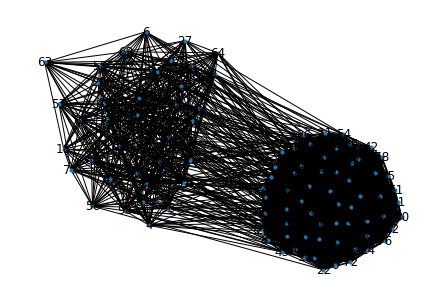

In [13]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [14]:
# true model
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [ ]:
def importance_sampling(iterations, A, d):
    
    p_list = []
    q_list = []
    hatX_list = []
    weight_list = []
    
    p, q, hatX = d_spectral_tensorly(A, d)
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)
    
    for i in range(iterations):

        Xi = tf.cast(tfp.distributions.Bernoulli(probs = hatM).sample(),     dtype = tf.float32)
        M  = tf.cast(tfp.distributions.Bernoulli(probs = bernoulli_param).sample(A.shape), dtype = tf.float32)

        p, q, hatX = d_spectral_tensorly(M*Xi + (1-M)*A, d)
        weight = likelihood_evaluation(A, hatM)
        
        p_list.append(p)
        q_list.append(q)
        hatX_list.append(hatX)
        weight_list.append(weight)

    return p_list, q_list, hatX_list, weight_list
